In [1]:
# IMPORT HEADERS

from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pylab as py

from scipy.optimize import curve_fit
from astropy.io import fits

In [2]:
# HELPER FUNCTIONS

def show_picture(data, low, high):
    """Shows a picture between 1st and 99th percentiles of 
    input data set, using plt"""
    fig = plt.figure(figsize = (10, 10))
    plt.imshow(data, origin = 'lower', cmap = 'gray_r', \
           vmin = np.percentile(data, low), \
           vmax = np.percentile(data, high))
    plt.axis('off')
    #plt.colorbar()
    plt.show()
    return

In [3]:
def make_histogram(data):
    """Plot a histogram from data"""
    hist = plt.hist((data).flatten(), bins = 40, color = 'k')
    plt.xscale('linear')
    plt.yscale('log')
    plt.axvline(np.percentile(data,99), ls = '--', color = 'red')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()
    return hist

In [4]:
def get_average(data):
    """Gets mean of data set (array of array)"""
    row_norms = []
    for row in data:
        # append norm from linear algebra package
        row_norms.append(np.mean(row))
    return np.mean(row_norms)

In [5]:
def gaussian_onepeak(x,*p):
    # A gaussian peak with:
    #   Peak height above background : p[0]
    #   Central value                : p[1]
    #   Standard deviation           : p[2]
    #   Background                   : p[3]
    
    return p[0]*np.exp(-1.*(x-p[1])**2/(2.*p[2]**2)) + p[3]

### (i) Read and display the bias, flat, arc and science frames

Bias data:


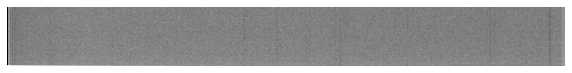

Flat data:


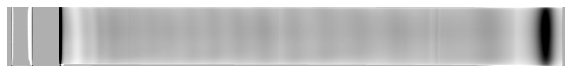

Histogram of flat data:


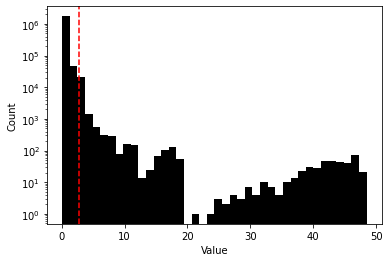

The mean of flat data is 1 as expected.
Arc data:


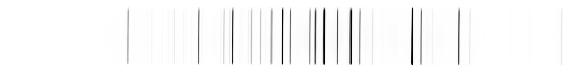

Science 0046 data:


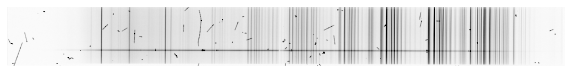

Science 0047 data:


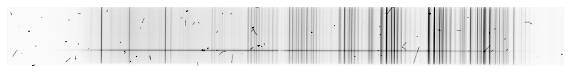

Science 0048 data:


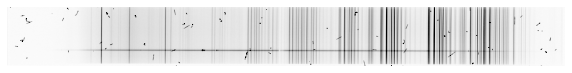

In [6]:
# Bias
bias = fits.open('bias.fits')
data_bias = bias[0].data.copy()
print("Bias data:")
show_picture(data_bias, 1, 99)

# Flat
flat = fits.open('flat.fits')
data_flat = flat[0].data.copy()
print("Flat data:")
show_picture(data_flat, 1, 99)

print("Histogram of flat data:")
make_histogram(data_flat)
print("The mean of flat data is", round(get_average(data_flat)), "as expected.")

# Arc
arc = fits.open('arc.fits')
data_arc = arc[0].data.copy()
print("Arc data:")
show_picture(data_arc, 1, 99)

# Science frames
science0046 = fits.open('sci0046.fits')
data_sc0046 = science0046[0].data.copy()
print("Science 0046 data:")
show_picture(data_sc0046, 1, 99)

science0047 = fits.open('sci0047.fits')
data_sc0047 = science0047[0].data.copy()
print("Science 0047 data:")
show_picture(data_sc0047, 1, 99)

science0048 = fits.open('sci0048.fits')
data_sc0048 = science0048[0].data.copy()
print("Science 0048 data:")
show_picture(data_sc0048, 1, 99)

#science.info()


### (ii) Read in the header and show DATE, EXPTIME, RA, DEC and OBJECT

In [7]:
science_header = science0046[0].header

In [8]:
print("Date of observation (in UTC):", science0046[0].header[25])
print("Exposure time was           :", science0046[0].header[23], "seconds")
print("Right Ascension is          :", science0046[0].header[41])   #ra
print("Declination is              :", science0046[0].header[42])   # dec
print("The object name is          :", science0046[0].header[12])


Date of observation (in UTC): 2019-06-08T04:56:18
Exposure time was           : 600.0 seconds
Right Ascension is          : 11:23:17.50
Declination is              : +24:02:13.2
The object name is          : NSA112250


### (iii) Median combine the science frames

Median combined science image: 


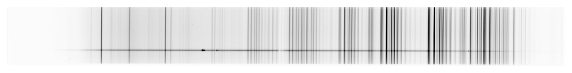

There are 440 rows in the combined science image.


In [9]:
science_list = [data_sc0046, data_sc0047, data_sc0048]
combined_science = []   # transfer to a new array, like in pset 6
for row_count in range(len(data_sc0046)):
    all_science_array = []
    for science in range(len(science_list)):
        all_science_array.append(science_list[science][row_count])
    row_median = np.median(all_science_array, axis = 0)
    combined_science.append(row_median)

print("Median combined science image: ")
show_picture(combined_science, 1, 99)
print("There are", len(combined_science), "rows in the combined science image.")

The science data is the long horizontal line representing the emissions spectrum from the NSA112250 object.
Compared to the individual science data frames, the median combined frame is cleaner with the "dots" and other random noise removed, since they do not show up in all three frames. 


### (iv) Reduce the combined science frame 

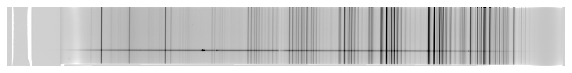

In [10]:
data_reduced = combined_science - data_bias   # subtract bias from combined science frame
data_reduced /= data_flat   # divide by the flat field
show_picture(data_reduced,1,99)

### (v) Read in reduced file

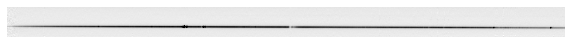

There are 161 rows in the reduced file spectrum.
In each row, there are 3001 pixels lengthwise.


In [11]:
file = 'reduce2d.fits'
hdu = fits.open(file)
data = hdu[1].data
flux2d = data['flux'][0,:,:]
wave2d = data['wave'][0,:,:]

show_picture(flux2d,1,99)
print("There are", len(flux2d), "rows in the reduced file spectrum.")
print("In each row, there are", len(flux2d[1]), "pixels lengthwise.")


One similar result with the median combined science iamge is the horizontal line, which represents the spectrum information. 

### (vi) Extract the science data

In [12]:
# define 1d science array as a column from the reduced file, say at x=200
vert_1d = []
vert_x = []   # for fitting, x axis

for row_idx in range(len(flux2d)):
    vert_1d.append(flux2d[row_idx][200])
    vert_x.append(row_idx)
    
print("To check: the vertical sample selected has", len(vert_1d), "pixels.")


To check: the vertical sample selected has 161 pixels.


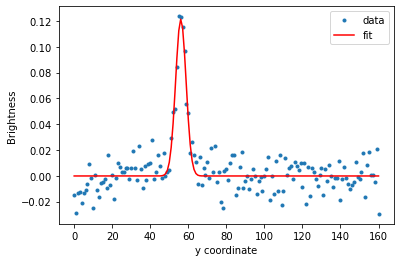

Peak height above background = 0.12
Central value                = 56.07
One Sigma                    = 2.75
Background                   = -0.00


In [13]:
# input height above background, central value, standard deviation and background estimate
p_init=[0.12,60,5,0.05]

# RUN CURVE_FIT
p, pcov = curve_fit(gaussian_onepeak, vert_x, vert_1d, p0=p_init)  

# USE THE SAME FUNCTION TO GENERATE A FIT
fit0 = gaussian_onepeak(vert_x,*p)

# AND OVERPLOT RESULTS
plt.plot(vert_x,vert_1d,'.',label='data')
plt.plot(vert_x,fit0,'r-',label='fit')
plt.legend()
plt.xlabel('y coordinate')
plt.ylabel('Brightness')
plt.show()

print('Peak height above background = {:0.2f}'.format(p[0]))
print('Central value                = {:0.2f}'.format(p[1]))
print('One Sigma                    = {:0.2f}'.format(p[2]))
print('Background                   = {:0.2f}'.format(p[3]))

sci_1d = wave2d[56]
flux_1d = flux2d[56]

From the Gaussian fit, we conclude the spatial peak is at y coordinate of 56. 

### (vii, viii) Plot science spectrum

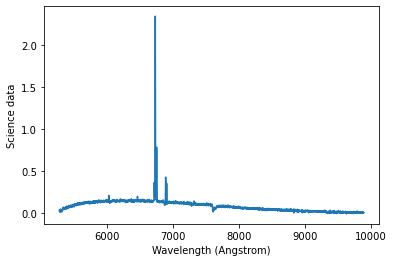

In [14]:
plt.plot(sci_1d, flux_1d)
plt.ylabel('Science data')
plt.xlabel('Wavelength (Angstrom)')
plt.show()

### (ix) Confirm sky absorption lines

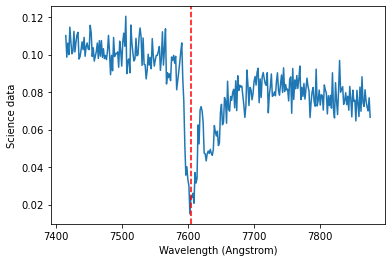

In [15]:
plt.plot(sci_1d[1400:1700], flux_1d[1400:1700])
plt.ylabel('Science data')
plt.xlabel('Wavelength (Angstrom)')
plt.axvline(7605, ls = '--', color = 'red')
plt.show()

Strong sky absorption observed near 7605 Angstroms. 

### (x) Determine a redshift

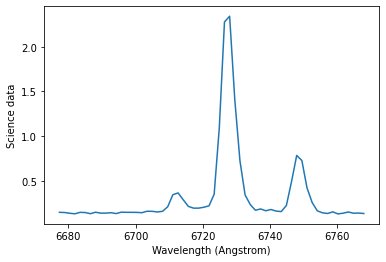

In [16]:
plt.plot(wave2d[56][920:980], flux2d[56][920:980])
plt.ylabel('Science data')
plt.xlabel('Wavelength (Angstrom)')
plt.show()
# peak observed about 6725 Ang

In [17]:
redshift = (6725 - 6562.8)/6552.8
velocity = (6725 - 6562.8)/6552.8*3*10**5  # in km/s

# Hubble's Law: v = H_0 * D where H_0 is 70 km/s /Mpc
distance = velocity/70

print("Redshift z is {:0.5f}".format(redshift))
print("Velocity is {:0.3f} km/s".format(velocity))
print("Distance is {:0.3f} Mpc".format(distance))
print()
print("At 106.08 Mpc from Earth, the object NSA112250 is slightly nearer than the galaxy in problem set #7, \
which was at 107.69 Mpc.")
# the values are consistent with the ned.ipac.caltech.edu search, which has velocity of 7811 +/- 22 km/s and
# distance of 115.20 +/- 8.07 Mpc. Inaccuracy in my results due to visual determination of emission peak. 

Redshift z is 0.02475
Velocity is 7425.833 km/s
Distance is 106.083 Mpc

At 106.08 Mpc from Earth, the object NSA112250 is slightly nearer than the galaxy in problem set #7, which was at 107.69 Mpc.


### Extra credit: Sky Subtraction

First, determine where the science data is at (vertical coordinate).

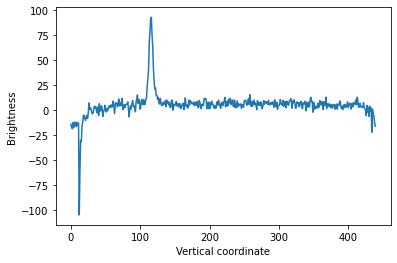

In [18]:
# define 1d science array as a column from the reduced file, say at x=200
vert_1d_extra = []
vert_x_extra = []   # for fitting, x axis

# get noisy science 1D spectrum from (iv) data_reduced 2D spectrum
for row_idx in range(len(data_reduced)):
    vert_1d_extra.append(data_reduced[row_idx][1000])
    vert_x_extra.append(row_idx)
    
plt.plot(vert_x_extra, vert_1d_extra)
plt.xlabel("Vertical coordinate")
plt.ylabel("Brightness")
plt.show()

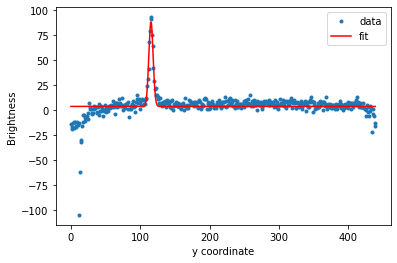

Peak height above background = 85.37
Central value                = 115.47
One Sigma                    = -3.06
Background                   = 3.81
The science data is at approximately column 115 from the fit.


In [19]:
# Fit to find vertical coordinate
p_init3=[100,150,5,1]
p3, pcov = curve_fit(gaussian_onepeak, vert_x_extra, vert_1d_extra, p0=p_init3)    
fit3 = gaussian_onepeak(vert_x_extra,*p3)

# overplot on vertical sample
plt.plot(vert_x_extra,vert_1d_extra,'.',label='data')
plt.plot(vert_x_extra,fit3,'r-',label='fit')
plt.legend()
plt.xlabel('y coordinate')
plt.ylabel('Brightness')
plt.show()

print('Peak height above background = {:0.2f}'.format(p3[0]))
print('Central value                = {:0.2f}'.format(p3[1]))
print('One Sigma                    = {:0.2f}'.format(p3[2]))
print('Background                   = {:0.2f}'.format(p3[3]))

print("The science data is at approximately column 115 from the fit.")

Data reduced spectrum:


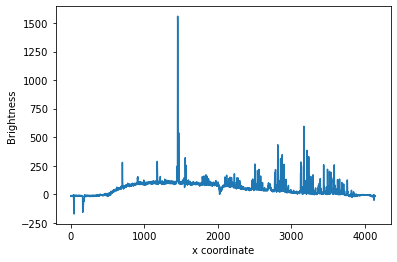

Combined sky spectrum:


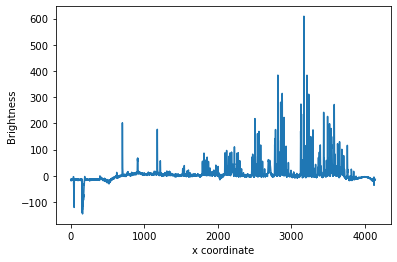

Removed sky spectrum:


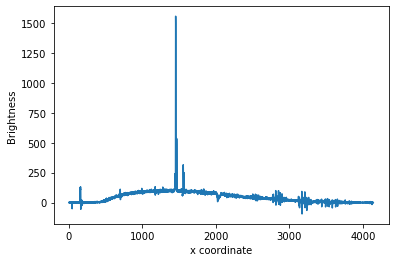

In [20]:
# Get sky background
away_row1 = data_reduced[100]
away_row2 = data_reduced[200]
away_row3 = data_reduced[300]

# length of each row is 4141 elements
# print(len(away_row2))   # 4141

# median combine the sky images
combined_sky = []
for x in range(4141):
    five_sky = [away_row1[x],away_row2[x],away_row3[x]]
    combined_sky.append(np.median(five_sky, axis = 0))

# subtract the sky from the science data    
removed_sky = []
for i in range(4141):
    removed_sky.append(data_reduced[115][i] - combined_sky[i])

# plot respective spectrums
print("Data reduced spectrum:")
plt.plot(data_reduced[115])
plt.xlabel('x coordinate')
plt.ylabel('Brightness')
plt.show()

print("Combined sky spectrum:")
plt.plot(combined_sky)
plt.xlabel('x coordinate')
plt.ylabel('Brightness')
plt.show()

print("Removed sky spectrum:")
plt.plot(removed_sky)
plt.xlabel('x coordinate')
plt.ylabel('Brightness')
plt.show()

The removed sky spectrum here has the same shape as before in (viii), but horizontal axis is in pixels instead of wavelength (since we have not yet calibrated the pixel to wavelength yet). 

Removed sky via full spectrum:


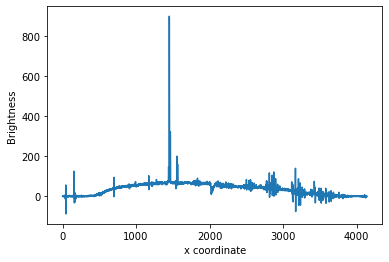

In [21]:
# Since the full width half max at about 10 pixel across, we take +/- 5 pixels

removed_sky2 = []
length_list = []
for x in range(4141):   # length per row
    value = 0           # this pixel
    for row_idx in range(110,120):
        value += 0.1*data_reduced[row_idx][x]   # 0.1 due to sum over 10 rows
    value -= combined_sky[x]                    # delete sky
    removed_sky2.append(value)
    length_list.append(x)                       # for fit later

print("Removed sky via full spectrum:")
plt.xlabel('x coordinate')
plt.ylabel('Brightness')
plt.plot(length_list,removed_sky2)
plt.show()

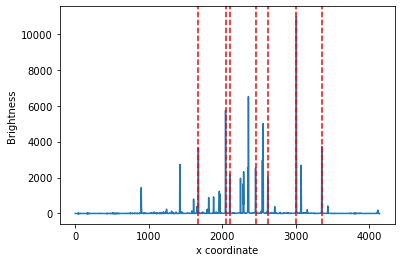

In [22]:
plt.plot(data_arc[115])
for wavelength in [1675.7, 2045.6, 2103.3, 2453.3, 2619.5, 3008, 3354]:
    plt.axvline(wavelength, ls = '--', color = 'red')
plt.xlabel('x coordinate')
plt.ylabel('Brightness')
plt.show()

In [23]:
lambda_list = [7065.2, 7635.0, 7724.1, 8264.5, 8521.44, 9122.9, 9657]   # lambda is reserved keyword
pix_list = [1675.7, 2045.6, 2103.3, 2453.3, 2619.5, 3008, 3354]

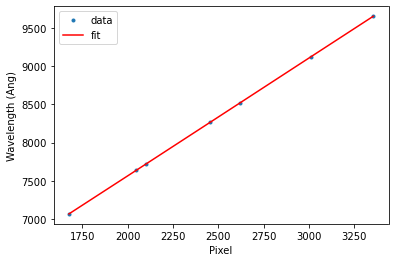

Fitted polynomial is y = -0.000000x^3 + 0.000025x^2 + 1.478839x + 4531.439956


In [24]:
# obtain pixel to wavelength fitting

def polynomial3d(x,*p):
    # Cubic polynomial fit of y = ax^3 + bx^2 + cx + d
    # a = p[0], b = p[1], c = p[2], d = p[3]
    return p[0]*np.power(x,3.0) + p[1]*np.power(x,2.0) + p[2]*np.power(x,1.0) + p[3]
    
p_init4=[1,1,1,1]
p4, pcov = curve_fit(polynomial3d, pix_list, lambda_list, p0=p_init4)    
fit4 = polynomial3d(pix_list,*p4)

# AND OVERPLOT RESULTS
plt.plot(pix_list,lambda_list,'.',label='data')
plt.plot(pix_list,fit4,'r-',label='fit')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Wavelength (Ang)')
plt.show()

print('Fitted polynomial is y = {:0.6f}x^3 + {:0.6f}x^2 + {:0.6f}x + {:0.6f}'.format(p4[0],p4[1],p4[2],p4[3]))
fit_coefficients = p4   # to use for conversion


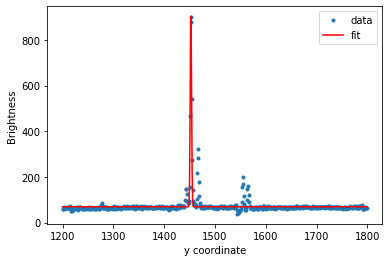

Peak height above background = 875.56
Central value                = 1452.60
One Sigma                    = 1.31
Background                   = 68.98


In [25]:
# Now we identify science peak; zoom in to 1200-1800 pixel range

# inputs: height above background, central value, standard deviation and background estimate
p_init5 = [800,1450,10,100]

# RUN CURVE_FIT
p5, pcov5 = curve_fit(gaussian_onepeak, length_list[1200:1800], removed_sky2[1200:1800], p0=p_init5)  

# USE THE SAME FUNCTION TO GENERATE A FIT
fit5 = gaussian_onepeak(length_list[1200:1800],*p5)

# AND OVERPLOT RESULTS
plt.plot(length_list[1200:1800],removed_sky2[1200:1800],'.',label='data')
plt.plot(length_list[1200:1800],fit5,'r-',label='fit')
plt.legend()
plt.xlabel('y coordinate')
plt.ylabel('Brightness')
plt.show()

print('Peak height above background = {:0.2f}'.format(p5[0]))
print('Central value                = {:0.2f}'.format(p5[1]))
print('One Sigma                    = {:0.2f}'.format(p5[2]))
print('Background                   = {:0.2f}'.format(p5[3]))

[-3.05592377e-09  2.49738417e-05  1.47883866e+00  4.53143996e+03]
Removed sky via full spectrum, by wavelength:


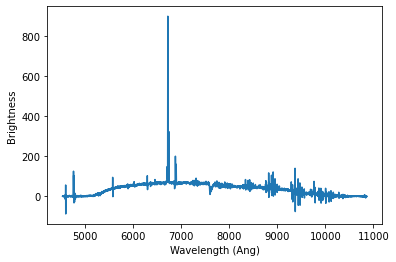

Checking for the A-band absorption:


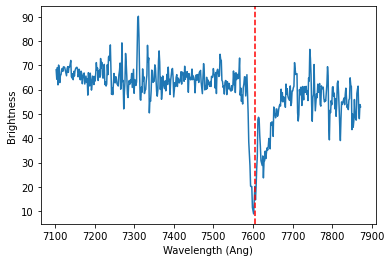

In [26]:
# central value is 1452 
print(fit_coefficients)

wavelength_list = []          # convert lengths to wavelength
for length in length_list:
    wavelength = -3.05592377e-09*length**3 + 2.49738417e-05*length**2 + 1.47883866e+00*length + 4.53143996e+03
    wavelength_list.append(wavelength)

print("Removed sky via full spectrum, by wavelength:")
plt.plot(wavelength_list,removed_sky2)
plt.xlabel("Wavelength (Ang)")
plt.ylabel("Brightness")
plt.show()

print("Checking for the A-band absorption:")
plt.plot(wavelength_list[1700:2200], removed_sky2[1700:2200])
plt.axvline(7605, ls = '--', color = 'red')
plt.xlabel("Wavelength (Ang)")
plt.ylabel("Brightness")
plt.show()

The dip shows the wavelength correction has worked, with results similar to part (ix). 